# Spike Time analyses

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve

## Load and Inspect Data

In this section, you will be introduced to three Python libraries essential for data loading and manipulation:

- **xarray**: A library to read NetCDF files and handle N-dimensional arrays with labeled axes.
  - **Example Functions and Syntax**:
    - `xarray.open_dataset('file.nc')`: Load a NetCDF file as an xarray Dataset.
    - `dataset.to_dataframe()`: Convert an xarray Dataset to a Pandas DataFrame.
- **Pandas**: For data manipulation and analysis.
  - **Example Functions and Syntax**:
    - `dataframe.head()`: View the first few rows of the DataFrame.
    - `dataframe.describe()`: Generate descriptive statistics.
- **NumPy**: For numerical operations.
  - **Example Functions and Syntax**:
    - `array = dataset["variable_name"].values`: Create a NumPy array from a variable in the xarray Dataset.
    - `array.mean()`: Compute the mean of array elements.

##### Load the data from the `filename.nc` file using xarray `load_dataset` method.

In [2]:
dset = xr.load_dataset("../../data/steinmetz_2016-12-14_Cori.nc")
dset

<xarray.Dataset>
Dimensions:             (trial: 364, time: 250, cell: 734,
                         waveform_component: 3, sample: 82, probe: 384,
                         brain_area_lfp: 7, spike_id: 2446173)
Coordinates:
  * trial               (trial) int32 1 2 3 4 5 6 7 ... 359 360 361 362 363 364
  * time                (time) float64 0.01 0.02 0.03 0.04 ... 2.48 2.49 2.5
  * cell                (cell) int32 1 2 3 4 5 6 7 ... 729 730 731 732 733 734
  * waveform_component  (waveform_component) int32 1 2 3
  * probe               (probe) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384
  * brain_area_lfp      (brain_area_lfp) object 'ACA' 'LS' ... 'SUB' 'VISp'
  * spike_id            (spike_id) int32 1 2 3 4 ... 2446171 2446172 2446173
Dimensions without coordinates: sample
Data variables: (12/31)
    contrast_left       (trial) int8 100 0 100 0 50 0 0 ... 0 100 50 50 0 25 100
    contrast_right      (trial) int8 0 50 50 0 100 0 0 ... 25 100 25 25 50 0 100
    gocue               (trial) float64 1.027 0.8744 0.8252 ... nan nan nan
    stim_onset          (trial) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feedback_type       (trial) float64 1.0 1.0 1.0 1.0 -1.0 ... nan nan nan nan
    feedback_time       (trial) float64 1.187 1.438 0.986 2.296 ... nan nan nan
    ...                  ...
    waveform_w          (cell, sample, waveform_component) float32 0.0 ... -0...
    waveform_u          (cell, waveform_component, probe) float32 0.0 ... 0.0
    lfp                 (brain_area_lfp, trial, time) float64 -2.851 ... 5.571
    spike_time          (spike_id) float32 0.2676 2.308 0.8535 ... 2.189 2.399
    spike_cell          (spike_id) uint32 1 1 1 1 1 1 ... 734 734 734 734 734
    spike_trial         (spike_id) uint32 21 21 31 37 43 ... 364 364 364 364 364
Attributes:
    session_date:  2016-12-14
    mouse:         Cori
    stim_onset:    0.5
    bin_size:      0.01

##### Select a subset of the dataset containing only `spike_cell` and `spike_time`.

In [3]:
cols = ["spike_cell", "spike_time"]
dset[cols]

<xarray.Dataset>
Dimensions:     (spike_id: 2446173)
Coordinates:
  * spike_id    (spike_id) int32 1 2 3 4 5 ... 2446170 2446171 2446172 2446173
Data variables:
    spike_cell  (spike_id) uint32 1 1 1 1 1 1 1 ... 734 734 734 734 734 734 734
    spike_time  (spike_id) float32 0.2676 2.308 0.8535 ... 0.6186 2.189 2.399
Attributes:
    session_date:  2016-12-14
    mouse:         Cori
    stim_onset:    0.5
    bin_size:      0.01

##### In the subset also include variable `spike_trial`.

In [4]:
cols = ["spike_trial", "spike_cell", "spike_time"]
dset[cols]

<xarray.Dataset>
Dimensions:      (spike_id: 2446173)
Coordinates:
  * spike_id     (spike_id) int32 1 2 3 4 5 ... 2446170 2446171 2446172 2446173
Data variables:
    spike_trial  (spike_id) uint32 21 21 31 37 43 46 ... 364 364 364 364 364 364
    spike_cell   (spike_id) uint32 1 1 1 1 1 1 1 ... 734 734 734 734 734 734 734
    spike_time   (spike_id) float32 0.2676 2.308 0.8535 ... 0.6186 2.189 2.399
Attributes:
    session_date:  2016-12-14
    mouse:         Cori
    stim_onset:    0.5
    bin_size:      0.01

##### Convert the subset into to a Pandas DataFrame.

In [5]:
df = dset[cols].to_dataframe().reset_index()
df

,spike_id,spike_trial,spike_cell,spike_time
0,1,21,1,0.267635
1,2,21,1,2.308335
2,3,31,1,0.853476
3,4,37,1,2.197501
4,5,43,1,2.452692
...,...,...,...,...
2446168,2446169,364,734,0.266459
2446169,2446170,364,734,0.587060
2446170,2446171,364,734,0.618560
2446171,2446172,364,734,2.188634


##### How many of the cells spiked in the first trial (i.e. trial 1)?

In [6]:
n_active_cells_trial_1 = df[df.spike_trial == 1]["spike_cell"].unique().shape[0]
n_active_cells_trial_1

487

##### What fraction of the total number of cells is that?

In [7]:
n_total_cells = df["spike_cell"].max()
n_total_cells

734

In [8]:
n_active_cells_trial_1 / n_total_cells

0.6634877384196185

##### How many times cell 1 spiked in trial 1?

In [9]:
n_cell1_spikes = df[(df.spike_trial == 1) & (df.spike_cell == 1)].shape[0]
n_cell1_spikes

0

## Visualize the spiking activity using spike times

In this section, you will learn about:

- **Matplotlib**: The go-to library for creating static, interactive, and animated visualizations.
  - `plt.scatter()`: Create scatter plots.
  - `plt.xlabel()`, `plt.ylabel()`: Label axes.
  - `plt.title()`: Add a title.
- **Seaborn**: Built on top of Matplotlib, it provides a high-level interface for drawing attractive and informative statistical graphics.
  - `sns.histplot()`: Create histograms to show distributions.
  - `sns.kdeplot()`: Plot Kernel Density Estimations.

##### Create a scatter plot to visualize spikes for a single neuron across multiple trials.

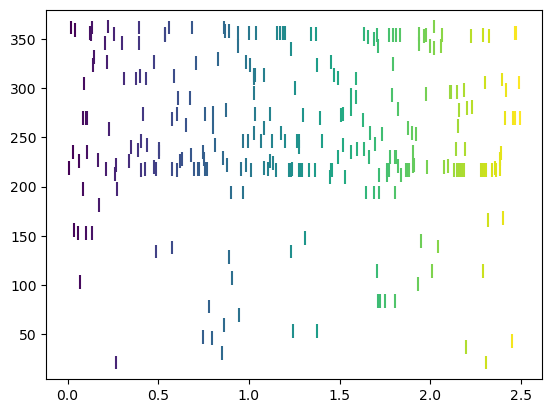

In [10]:
dd = df[df.spike_cell == 1].copy()
plt.scatter(dd.spike_time, dd.spike_trial, marker="|", s=100, c=dd.spike_time);

##### Create a scatter plot to visualize spikes for all neurons in trial 1.

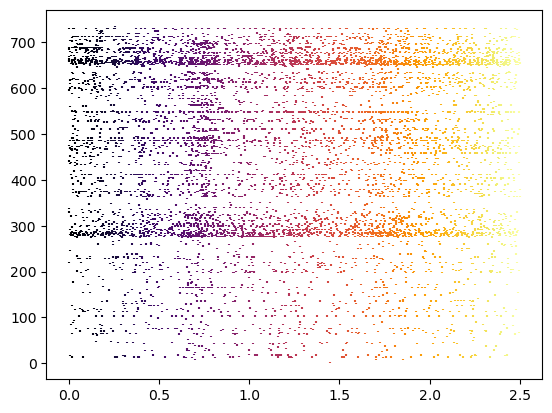

In [11]:
dd = df[df.spike_trial == 1].copy()
plt.scatter(dd.spike_time, dd.spike_cell, marker="|", s=1, c=dd.spike_time, cmap="inferno");

##### Create a histogram (or KDE) of spikes using some seaborn plotting functions.

<Axes: xlabel='spike_time', ylabel='Count'>

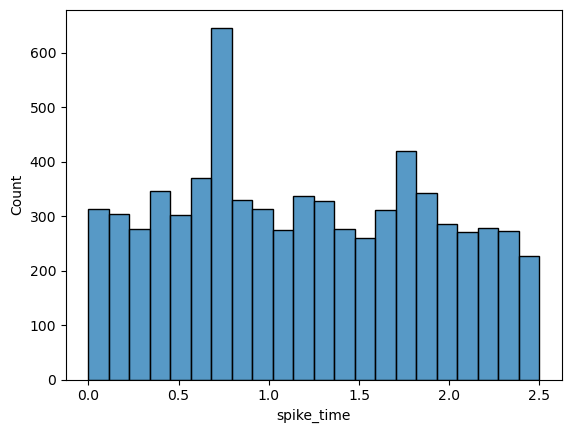

In [12]:
sns.histplot(data=dd, x="spike_time")
# sns.rugplot(data=dd, x="spike_time", height=.1, c="crimson")

##### Overlay the spikes with the histrogram (or KDE).

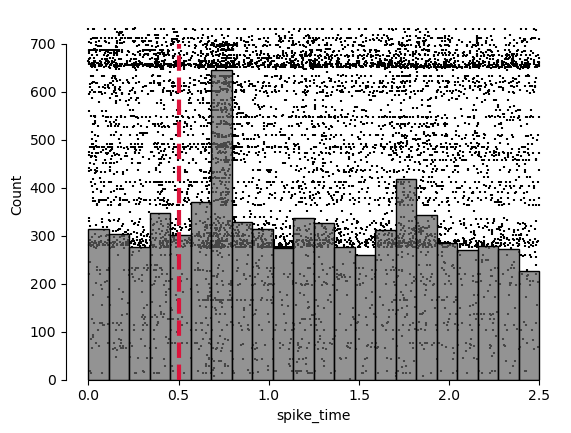

In [13]:
dd = df[df.spike_trial == 1].copy()
plt.scatter(dd.spike_time, dd.spike_cell, marker="|", s=1, c="k", zorder=0) #dd.spike_time, cmap="k");
sns.histplot(data=dd, x="spike_time", color=".4", alpha=.7, zorder=1)
plt.plot([.5, .5], [0, 700], lw=3, ls="--", c="crimson", zorder=2)
sns.despine(trim=True)

##### Save the plot as a pdf file

## Visualize the spiking activity for different brain areas

##### Create a dataframe that contains the brain area for each cell.

In [14]:
brain_region_df = dset["brain_area"].to_dataframe().reset_index()
brain_region_df

,cell,brain_area
0,1,ACA
1,2,MOs
2,3,ACA
3,4,LS
4,5,MOs
...,...,...
729,730,SUB
730,731,DG
731,732,DG
732,733,VISp


##### What brain areas were recorded from this specific mouse?

In [15]:
brain_region_df.brain_area.unique()

array(['ACA', 'MOs', 'LS', 'root', 'VISp', 'CA3', 'SUB', 'DG'],
      dtype=object)

##### Merge the brain area dataframe and the spike time dataframe.

In [16]:
cols = ['spike_trial', 'spike_cell', 'spike_time']
spike_times_df = dset[cols].to_dataframe().reset_index()
spike_times_df

,spike_id,spike_trial,spike_cell,spike_time
0,1,21,1,0.267635
1,2,21,1,2.308335
2,3,31,1,0.853476
3,4,37,1,2.197501
4,5,43,1,2.452692
...,...,...,...,...
2446168,2446169,364,734,0.266459
2446169,2446170,364,734,0.587060
2446170,2446171,364,734,0.618560
2446171,2446172,364,734,2.188634


In [17]:
brain_region_df = brain_region_df.rename(columns={"cell": "spike_cell"})

In [18]:
brain_region_df

,spike_cell,brain_area
0,1,ACA
1,2,MOs
2,3,ACA
3,4,LS
4,5,MOs
...,...,...
729,730,SUB
730,731,DG
731,732,DG
732,733,VISp


In [19]:
df = pd.merge(spike_times_df, brain_region_df)

In [20]:
df

,spike_id,spike_trial,spike_cell,spike_time,brain_area
0,1,21,1,0.267635,ACA
1,2,21,1,2.308335,ACA
2,3,31,1,0.853476,ACA
3,4,37,1,2.197501,ACA
4,5,43,1,2.452692,ACA
...,...,...,...,...,...
2446168,2446169,364,734,0.266459,DG
2446169,2446170,364,734,0.587060,DG
2446170,2446171,364,734,0.618560,DG
2446171,2446172,364,734,2.188634,DG


##### Create a scatter plot of spike times for neurons, where neurons are colored based the area they belog to.

<Axes: xlabel='spike_time', ylabel='spike_cell'>

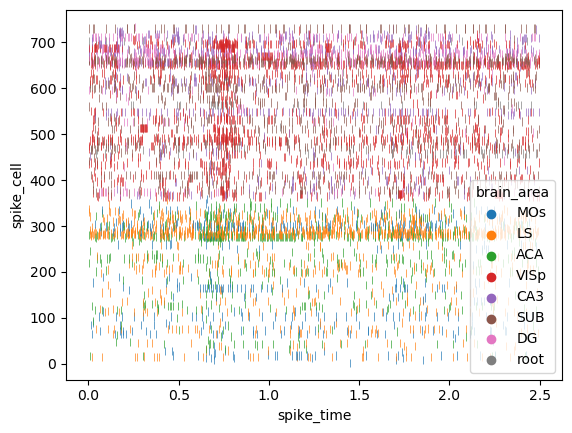

In [21]:
dd = df[df.spike_trial == 1].copy()
sns.scatterplot(x=dd.spike_time, y=dd.spike_cell, marker="|", hue=dd.brain_area) #, c=dd.brain_area, cmap="inferno");

##### Create the same scatter plot as prevous exercise but make sure to have neurons that belong to the same brain area are right after each other.

<Axes: xlabel='spike_time', ylabel='ordered_cell_idx'>

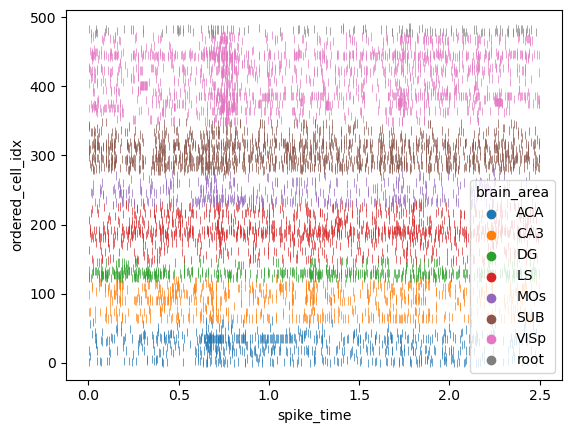

In [22]:
dd = df[df.spike_trial == 1].copy()
dd = dd.sort_values(by="brain_area")
dd["ordered_cell_idx"] = dd.spike_cell.factorize()[0]
sns.scatterplot(x=dd.spike_time, y=dd.ordered_cell_idx, marker="|", hue=dd.brain_area) #, c=dd.brain_area, cmap="inferno");